In [ ]:
import time
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_embed, reg_nn_lmm
from lmmnn.simulation import Count

import tensorflow.keras.backend as K

In [ ]:
# IMDB dataset from Kaggle: https://www.kaggle.com/datasets/wrandrall/imdb-new-dataset
# Run imdb_etl.R script
imdb = pd.read_csv(r'D:\Notes\Sem - 6\Thesis\Mixed Effect Model\Lit\datasets\imdb_database.csv')
print(imdb.shape)
imdb.head()

(189900, 14)


,Movie Name,Movie Date,Serie Name,Serie Date,Movie Type,Number of Votes,Movie Revenue (M$),Score,Metascore,Time Duration (min),Director,Actors,Restriction,Description
0,Les évadés,(1994),None,None,Drama,2294987,28341469,9.3,80,142,['Frank Darabont'],"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...",Tous publics,Two imprisoned men bond over a number of years...
1,The Dark Knight: Le chevalier noir,(2008),None,None,"Action, Crime, Drama",2259829,534858444,9.0,84,152,['Christopher Nolan'],"['Christian Bale', 'Heath Ledger', 'Aaron Eckh...",Tous publics,When the menace known as the Joker wreaks havo...
2,Inception,(2010),None,None,"Action, Adventure, Sci-Fi",2021865,292576195,8.8,74,148,['Christopher Nolan'],"['Leonardo DiCaprio', 'Joseph Gordon-Levitt', ...",Tous publics,A thief who steals corporate secrets through t...
3,Fight Club,(1999),None,None,Drama,1819635,37030102,8.8,66,139,['David Fincher'],"['Brad Pitt', 'Edward Norton', 'Meat Loaf', 'Z...",16,An insomniac office worker and a devil-may-car...
4,Pulp Fiction,(1994),None,None,"Crime, Drama",1792272,107928762,8.9,94,154,['Quentin Tarantino'],"['John Travolta', 'Uma Thurman', 'Samuel L. Ja...",12,"The lives of two mob hitmen, a boxer, a gangst..."


In [ ]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189900 entries, 0 to 189899
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Movie Name           189900 non-null  object 
 1   Movie Date           189895 non-null  float64
 2   Serie Name           189899 non-null  object 
 3   Serie Date           189897 non-null  object 
 4   Movie Type           189900 non-null  object 
 5   Number of Votes      189900 non-null  int64  
 6   Movie Revenue (M$)   189900 non-null  object 
 7   Score                189900 non-null  float64
 8   Metascore            189900 non-null  object 
 9   Time Duration (min)  189900 non-null  object 
 10  Director             189900 non-null  object 
 11  Actors               189900 non-null  object 
 12  Restriction          189900 non-null  object 
 13  Description          189900 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 20.3+ MB


In [ ]:
imdb.columns

Index(['Movie Name', 'Movie Date', 'Serie Name', 'Serie Date', 'Movie Type',
       'Number of Votes', 'Movie Revenue (M$)', 'Score', 'Metascore',
       'Time Duration (min)', 'Director', 'Actors', 'Restriction',
       'Description'],
      dtype='object')

In [ ]:
col_to_select = ['Movie Date','Movie Type',
       'Number of Votes', 'Score',
       'Time Duration (min)', 'Director']

In [ ]:
df = imdb[col_to_select]

,Movie Date,Movie Type,Number of Votes,Score,Time Duration (min),Director
0,1994.0,Drama,2294987,9.3,142,['Frank Darabont']
1,2008.0,"Action, Crime, Drama",2259829,9.0,152,['Christopher Nolan']
2,2010.0,"Action, Adventure, Sci-Fi",2021865,8.8,148,['Christopher Nolan']
3,1999.0,Drama,1819635,8.8,139,['David Fincher']
4,1994.0,"Crime, Drama",1792272,8.9,154,['Quentin Tarantino']


In [ ]:
df.head()

,Movie Date,Movie Type,Number of Votes,Score,Time Duration (min),Director
0,1994.0,Drama,2294987,9.3,142.0,['Frank Darabont']
1,2008.0,"Action, Crime, Drama",2259829,9.0,152.0,['Christopher Nolan']
2,2010.0,"Action, Adventure, Sci-Fi",2021865,8.8,148.0,['Christopher Nolan']
3,1999.0,Drama,1819635,8.8,139.0,['David Fincher']
4,1994.0,"Crime, Drama",1792272,8.9,154.0,['Quentin Tarantino']


In [ ]:
len(imdb[imdb['Time Duration (min)'] == 'None'])

10511

In [ ]:
try: 
    imdb["Time Duration (min)"] = imdb["Time Duration (min)"].astype(int)
except ValueError: pass

In [ ]:
df['Time Duration (min)'] = pd.to_numeric(df['Time Duration (min)'], errors='coerce')

C:\Users\htals\AppData\Local\Temp\ipykernel_17492\3806057285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time Duration (min)'] = pd.to_numeric(df['Time Duration (min)'], errors='coerce')


In [ ]:
df['Time Duration (min)'].fillna(df['Time Duration (min)'].median(), inplace=True)

C:\Users\htals\AppData\Local\Temp\ipykernel_17492\1126501822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time Duration (min)'].fillna(df['Time Duration (min)'].median(), inplace=True)


In [ ]:
df['Director'] = df['Director'].astype('category').cat.codes
df['Movie Type'] = df['Movie Type'].astype('category').cat.codes

C:\Users\htals\AppData\Local\Temp\ipykernel_17492\718288215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Director'] = df['Director'].astype('category').cat.codes
C:\Users\htals\AppData\Local\Temp\ipykernel_17492\718288215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie Type'] = df['Movie Type'].astype('category').cat.codes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189900 entries, 0 to 189899
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Movie Date           189895 non-null  float64
 1   Movie Type           189900 non-null  int16  
 2   Number of Votes      189900 non-null  int64  
 3   Score                189900 non-null  float64
 4   Time Duration (min)  189900 non-null  float64
 5   Director             189900 non-null  int32  
dtypes: float64(3), int16(1), int32(1), int64(1)
memory usage: 6.9 MB


In [ ]:
df.dropna(axis=1, inplace=True)
df.reset_index(inplace=True)

C:\Users\htals\AppData\Local\Temp\ipykernel_17492\229704750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True)


In [ ]:
df.drop('index', axis=1, inplace=True)
df

C:\Users\htals\AppData\Local\Temp\ipykernel_17492\1796563085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('index', axis=1, inplace=True)


,Movie Type,Number of Votes,Score,Time Duration (min),Director
0,1104,2294987,9.3,142.0,12972
1,60,2259829,9.0,152.0,7507
2,18,2021865,8.8,148.0,7507
3,1104,1819635,8.8,139.0,9405
4,814,1792272,8.9,154.0,33158
...,...,...,...,...,...
189895,1104,152,6.5,83.0,43621
189896,712,152,7.5,90.0,10745
189897,907,152,7.0,91.0,14732
189898,372,152,4.6,77.0,44099


In [ ]:
df.describe()

,Movie Type,Number of Votes,Score,Time Duration (min),Director
count,189900.000000,1.899000e+05,189900.000000,189900.000000,189900.000000
mean,763.738731,6.920610e+04,6.936210,73.994718,24264.236630
std,480.384359,2.991782e+05,1.439364,49.979846,13624.902436
min,0.000000,1.520000e+02,1.000000,1.000000,0.000000
25%,405.000000,2.440000e+02,6.100000,42.000000,12562.000000
50%,703.000000,4.740000e+02,7.200000,77.000000,24345.000000
75%,1104.000000,1.332000e+03,8.000000,97.000000,36243.000000
max,1964.000000,2.294987e+06,10.000000,5220.000000,44099.000000


In [ ]:
imdb['Movie Date'] = imdb['Movie Date'].str.replace(r'\D', '')

# Extract only the first 4 digits as the starting year
imdb['Movie Date'] = imdb['Movie Date'].str[:4]

# Convert the 'Year' column to numeric values
imdb['Movie Date'] = pd.to_numeric(imdb['Movie Date'], errors='coerce')


C:\Users\htals\AppData\Local\Temp\ipykernel_17492\1282196860.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  imdb['Movie Date'] = imdb['Movie Date'].str.replace(r'\D', '')


In [ ]:
imdb.to_csv("imdb.csv")

In [ ]:
imdb['Year'].isna().sum()

5

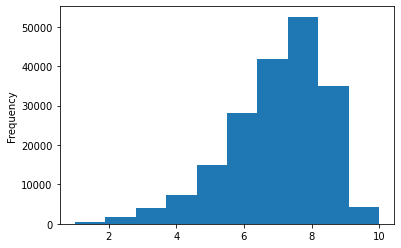

In [ ]:
imdb['Score'].plot(kind='hist')
plt.show()

In [ ]:
print(len(df['Director'].unique()))
print(df['Director'].max())

44100
44099


In [ ]:
n_cats_director = len(imdb['Director'].unique())
n_cats_type = len(imdb['Movie Type'].unique())
print(f'no. of directors: {n_cats_director}')
print(f'no. of types: {n_cats_type}')

no. of directors: 44100
no. of types: 1965


In [ ]:
df.rename(columns={'Director': 'z0',
                    'Movie Type': 'z1'}, inplace=True)

C:\Users\htals\AppData\Local\Temp\ipykernel_17492\2689328537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Director': 'z0',


In [ ]:
imdb['z0'] = imdb['z0'].astype('category').cat.codes
imdb['z1'] = imdb['z1'].astype('category').cat.codes

In [ ]:
df = df.sample(50000)
df.reset_index(drop=True, inplace=True)
df

,z1,Number of Votes,Score,Time Duration (min),z0
0,1258,310,7.6,30.0,44099
1,827,444,4.7,109.0,39668
2,1046,1430,8.3,103.0,36749
3,500,212,5.5,3.0,11920
4,590,210,6.9,30.0,44099
...,...,...,...,...,...
49995,1194,157,5.9,102.0,8815
49996,950,171,7.9,122.0,16392
49997,824,153,7.9,43.0,31690
49998,372,343,8.0,19.0,44099


In [ ]:
df["extra"] = np.random.randint(1, 10, size = 50000)

In [ ]:
dummy = pd.get_dummies(df['extra'])
df = pd.concat([df, dummy], axis=1)
df.drop('extra', axis=1, inplace=True)
df

,z1,Number of Votes,Score,Time Duration (min),z0,1,2,3,4,5,6,7,8,9
0,1258,310,7.6,30.0,44099,0,1,0,0,0,0,0,0,0
1,827,444,4.7,109.0,39668,0,0,0,0,0,1,0,0,0
2,1046,1430,8.3,103.0,36749,1,0,0,0,0,0,0,0,0
3,500,212,5.5,3.0,11920,0,0,0,0,0,0,0,0,1
4,590,210,6.9,30.0,44099,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1194,157,5.9,102.0,8815,0,0,0,0,0,1,0,0,0
49996,950,171,7.9,122.0,16392,0,0,0,0,0,0,1,0,0
49997,824,153,7.9,43.0,31690,0,0,0,0,0,0,1,0,0
49998,372,343,8.0,19.0,44099,0,1,0,0,0,0,0,0,0


In [ ]:
df.rename(columns={1: 'a',
                    2: 'b',
                   3: 'b',
                    4: 'd',
                   5: 'e',
                    6: 'f',
                   7: 'g',
                    8: 'h',
                   9: 'i'}, inplace=True)

In [ ]:
df2 = df.copy()
df2["Score"] = np.random.randint(0,2, size=len(df2))
df2.Score.value_counts()

0    25028
1    24972
Name: Score, dtype: int64

# Now on Synthetic Data

In [1]:
import numpy as np
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(np.random.randint(0,200, size=1))

# Define the number of schools and students
num_schools = 20
students_per_school = 1000

# Generate random school IDs for each student
school_ids = np.repeat(np.arange(num_schools), students_per_school)

# Generate random student IDs within each school
student_ids = np.tile(np.arange(students_per_school), num_schools)

# Generate random student scores
student_scores = np.random.normal(0, 1, size=num_schools * students_per_school)

# Generate random student ages
student_ages = np.random.randint(15, 20, size=num_schools * students_per_school)

# Generate nested ID columns
num_nested_ids = 50  # Number of nested ID columns
nested_ids = []
for i in range(num_nested_ids):
    nested_ids.append(np.random.randint(1, 10, size=num_schools * students_per_school))

# Create a DataFrame to store the dataset
data = pd.DataFrame({'SchoolID': school_ids, 'StudentID': student_ids, 'Score': student_scores,
                     'Age': student_ages})

# Add nested ID columns to the DataFrame
for i in range(num_nested_ids):
    column_name = f'NestedID{i+1}'
    data[column_name] = nested_ids[i]

# Print the first few rows of the dataset
data.head()

,SchoolID,StudentID,Score,Age,NestedID1,NestedID2,NestedID3,NestedID4,NestedID5,NestedID6,...,NestedID41,NestedID42,NestedID43,NestedID44,NestedID45,NestedID46,NestedID47,NestedID48,NestedID49,NestedID50
0,0,0,1.551339,16,5,8,2,6,4,6,...,2,5,2,5,5,1,9,9,9,5
1,0,1,0.079186,18,3,6,7,7,9,4,...,5,2,9,1,7,2,3,6,3,2
2,0,2,0.173977,19,1,4,9,7,8,9,...,6,3,1,5,1,1,2,5,8,2
3,0,3,-0.072337,19,3,9,5,2,7,1,...,3,7,7,1,4,3,4,2,1,2
4,0,4,-2.004329,18,4,2,9,1,4,8,...,8,1,6,7,3,5,4,1,8,1


In [2]:
data.groupby(["StudentID", "SchoolID"]).size() 

StudentID  SchoolID
0          0           1
           1           1
           2           1
           3           1
           4           1
                      ..
999        15          1
           16          1
           17          1
           18          1
           19          1
Length: 20000, dtype: int64

In [3]:
# for i, row in data[["StudentID", "SchoolID"]].drop_duplicates().iterrows():
#     print(row["StudentID"], row["StudentID"])

In [ ]:
n_cats_director = len(data['SchoolID'].unique())
n_cats_type = len(data['StudentID'].unique())
print(f'no. of directors: {n_cats_director}')
print(f'no. of types: {n_cats_type}')

no. of directors: 20
no. of types: 1000


In [ ]:
data.rename(columns={'SchoolID': 'z0',
                    'StudentID': 'z1'}, inplace=True)

In [ ]:
batch = 100
epochs = 100
patience = 10
mode = 'intercepts'
n_sig2bs = 2
est_cors = []
n_neurons = [10, 3]
activation = 'relu'
dropout = []
spatial_embedded_neurons = []
qs = [n_cats_director, n_cats_type]
dist_matrix = None
q_spatial = None
Z_non_linear = False
Z_embed_dim_pct = 10
n_sig2bs_spatial = 0
time2measure_dict = None
spatial_embed_neurons = None
resultion = None
verbose = True
log_params = False
idx = None

In [ ]:
def reg_nn(X_train, X_test, y_train, y_test, reg_type):
    start = time.time()
    if reg_type == 'lmm':
        y_pred, sigmas, _, _, n_epochs = reg_nn_lmm(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode,
            n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons, verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)
    elif reg_type == 'ignore':
        y_pred, sigmas, _, _, n_epochs = reg_nn_ohe_or_ignore(
            X_train, X_test, y_train, y_test, qs, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode, n_sig2bs, n_sig2bs_spatial, est_cors, verbose, ignore_RE=True)
    elif reg_type == 'embed':
        y_pred, sigmas, _, _, n_epochs = reg_nn_embed(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode, n_sig2bs, n_sig2bs_spatial, est_cors, verbose)
    else:
        raise ValueError(reg_type + 'is an unknown reg_type')
    end = time.time()
    K.clear_session()
    gc.collect()
#     y_pred = np.clip(y_pred, 1, 10)
    mse = np.mean((y_pred - y_test)**2)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.show()
    return mse, sigmas, n_epochs, end - start, y_pred

In [ ]:
res = pd.DataFrame(columns=['experiment', 'exp_type', 'mse', 'sigma_e_est',
                            'sigma_b0_est', 'sigma_b1_est', 'n_epoch', 'time'])
counter = Count().gen()

def iterate_reg_types(X_train, X_test, y_train, y_test):
    mse_lmm, sigmas, n_epochs_lmm, time_lmm, y_pred = reg_nn(X_train, X_test, y_train, y_test, reg_type='lmm')
    print(' finished lmm, mse: %.4f' % (mse_lmm))
#     mse_ig, _, n_epochs_ig, time_ig = reg_nn(X_train, X_test, y_train, y_test, reg_type='ignore')
#     print(' finished ignore, mse: %.4f' % (mse_ig))
#     mse_em, _, n_epochs_em, time_em = reg_nn(X_train, X_test, y_train, y_test, reg_type='embed')
#     print(' finished embed, mse: %.4f' % (mse_em))
    res.loc[next(counter)] = [i, 'lmm', mse_lmm, sigmas[0], sigmas[1][0], sigmas[1][1],
                              n_epochs_lmm, time_lmm]
#     res.loc[next(counter)] = [i, 'ignore', mse_ig, np.nan, np.nan, np.nan, n_epochs_ig, time_ig]
#     res.loc[next(counter)] = [i, 'embed', mse_em, np.nan, np.nan, np.nan, n_epochs_em, time_em]
    return y_pred
    
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# X, y = df2.drop('Score', axis=1), df2['Score']
X, y = data.drop('Score', axis=1), data['Score']
x_cols = [col for col in X.columns if col not in ['z0', 'z1', 'z2']]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# # X, y = df.drop('Score', axis=1), df['Score']
# X, y = data.drop('Score', axis=1), data['Score']
# x_cols = [col for col in X.columns if col not in ['z0', 'z1', 'z2']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

iteration 49
Epoch 1/100
121/121 [==============================] - 1s 2ms/step - loss: 152.1340 - val_loss: 142.3151
Epoch 2/100
121/121 [==============================] - 0s 1ms/step - loss: 148.7657 - val_loss: 139.4313
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 146.2715 - val_loss: 137.0227
Epoch 4/100
121/121 [==============================] - 0s 1ms/step - loss: 144.5132 - val_loss: 135.4310
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 143.5778 - val_loss: 134.5722
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 142.8551 - val_loss: 132.9958
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 141.9272 - val_loss: 132.9953
Epoch 8/100
121/121 [==============================] - 0s 1ms/step - loss: 141.9094 - val_loss: 132.9626
Epoch 9/100
121/121 [==============================] - 0s 1ms/step - loss: 141.9061 - val_loss: 132.9548
Epoch 10/100
121/121 [====================

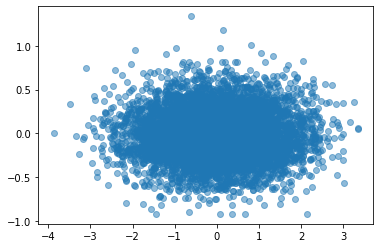

 finished lmm, mse: 1.0957


In [ ]:
print('iteration %d' % i)
# X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y[train_index], y[test_index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_pred = iterate_reg_types(X_train, X_test, y_train, y_test)

In [ ]:
y_pred, y_test

(array([ 0.04591711,  0.22090194, -0.15801276, ...,  0.03614506,
        -0.36986542, -0.04659199]),
 10650   -0.197471
 2041     1.491666
 8668    -0.101190
 1114     2.749588
 13902    1.024436
            ...   
 5388     0.463245
 749     -0.850303
 611      1.434713
 13637   -0.163668
 11617    1.161533
 Name: Score, Length: 6600, dtype: float64)

In [ ]:
res

,experiment,exp_type,mse,sigma_e_est,sigma_b0_est,sigma_b1_est,n_epoch,time
2,49,lmm,1.095655,0.503201,1.000000e-18,0.503201,28,6.980099


# Now with Mixedlm 

In [ ]:
data.head()

,z0,z1,Score,Age,NestedID1,NestedID2,NestedID3,NestedID4,NestedID5,NestedID6,...,NestedID41,NestedID42,NestedID43,NestedID44,NestedID45,NestedID46,NestedID47,NestedID48,NestedID49,NestedID50
0,0,0,0.473717,17,7,3,2,2,5,9,...,6,2,6,2,3,3,6,2,7,7
1,0,1,1.637603,17,3,9,5,9,5,2,...,1,9,7,1,4,8,4,8,2,1
2,0,2,0.998542,18,2,5,3,6,7,7,...,9,9,7,4,2,3,9,6,1,3
3,0,3,-0.707407,18,5,5,3,5,1,4,...,6,5,9,2,2,3,1,6,6,2
4,0,4,-1.042207,18,9,9,1,6,8,3,...,8,2,9,7,3,4,1,3,5,8


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 
x_cols = [col for col in X.columns if col not in ['z0', 'z1', 'z2', 'Score']]
# formula = f"Score ~ {' + '.join(x_cols)} + (1 | z0)"

formula = "Score ~ Age + (1 | z0) + (1 | NestedID1)"

In [ ]:
formula

'Score ~ Age + (1 | z0) + (1 | NestedID1)'

In [ ]:
md = sm.MixedLM.from_formula(formula, data, groups = data['z1'])
mdf = md.fit()
print(mdf.summary())

C:\Users\htals\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\htals\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\htals\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Score      
No. Observations: 20000   Method:             REML       
No. Groups:       1000    Scale:              1.0072     
Min. group size:  20      Log-Likelihood:     -28480.2051
Max. group size:  20      Converged:          Yes        
Mean group size:  20.0                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.045    0.088  0.517 0.605 -0.127  0.217
Age            -0.003    0.005 -0.498 0.618 -0.012  0.007
1 | z0          0.000    0.001  0.080 0.936 -0.002  0.003
1 | NestedID1  -0.000    0.003 -0.174 0.862 -0.006  0.005
Group Var       0.001    0.003                           



In [ ]:
import seaborn as sns

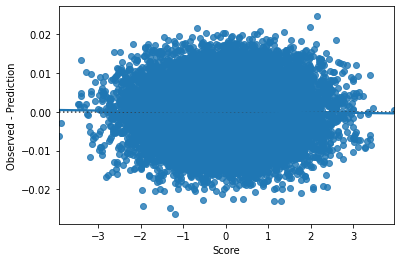

In [ ]:
performance_mem = pd.DataFrame()
performance_mem["residuals"] = mdf.resid.values
performance_mem["Score"] = data.Score
performance_mem["predicted"] = mdf.fittedvalues

ax = sns.residplot(x = "Score", y = "residuals", data = performance_mem, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [ ]:
mse = np.mean((mdf.fittedvalues - data.Score)**2)
mse

1.0057404947696498

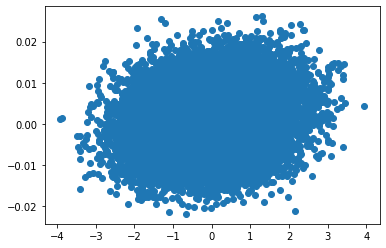

In [ ]:
plt.scatter(data.Score, mdf.fittedvalues)

# Test

In [1]:
import numpy as np

def cartesian(arrays, out=None):
    """
    Source: https://stackoverflow.com/a/1235363
    Generate a Cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the Cartesian product of.
    out : ndarray
        Array to place the Cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing Cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

<Axes: >

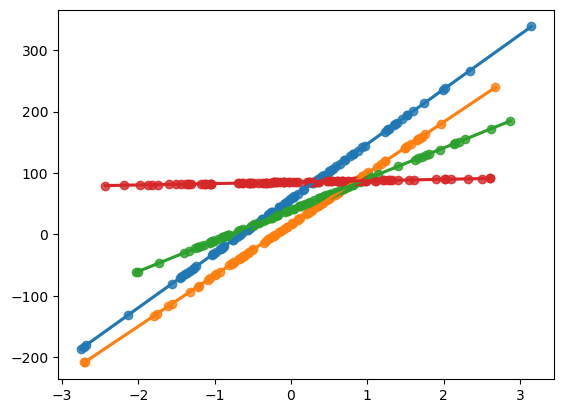

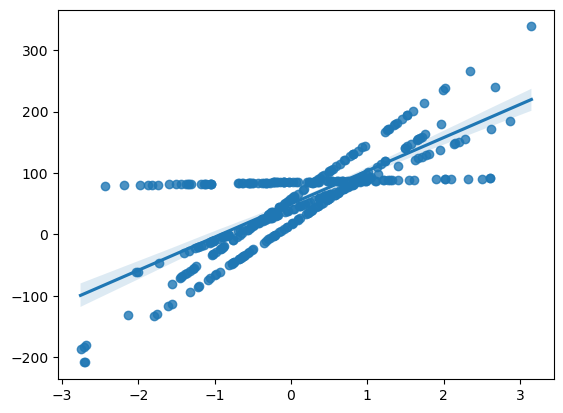

In [114]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns

meaningful_groups = {"g1": [0,1], "g2": [0,1]}
dummy_groups = {f"d{i}": [0,1] for i in range(1)}

n_features = 1
n_samples_per_group = 100
combinations = cartesian([v for v in meaningful_groups.values()])
X_list = []
y_list = []
for c in combinations:
    X, y = make_regression(n_samples=n_samples_per_group, n_features=n_features)
    y +=  np.random.random() * 100
    X_list.append(X)
    y_list.append(y)
    sns.regplot(x=X[:,0], y=y)

X_features = np.concatenate(X_list, axis=0)
X_groups = np.repeat(combinations, n_samples_per_group, axis=0)
X = np.concatenate([X_features, X_groups], axis=1)

y = np.concatenate(y_list)

plt.figure()
sns.regplot(x=X[:,0], y=y)

In [67]:
# from sklearn.datasets import make_regression
# import matplotlib.pyplot as plt
# import seaborn as sns

# meaningful_groups = {"g1": [0,1]}
# dummy_groups = {f"d{i}": [0,1] for i in range(1)}

# n_features = 1
# n_samples_per_group = 100
# combinations = cartesian([v for v in meaningful_groups.values()])
# X_list = []
# y_list = []
# X, y = make_regression(n_samples=n_samples_per_group * len(combinations), n_features=n_features)
# start = 0
# for c in combinations:
#     y[start:(start+n_samples_per_group)] += np.random.random() * 100
#     start =+ n_samples_per_group
#     sns.regplot(x=X[start:(start+n_samples_per_group),0], y=y[start:(start+n_samples_per_group)])

# X_features = X
# X_groups = np.repeat(combinations, n_samples_per_group, axis=0)
# print(X.shape, X_groups.shape)
# X = np.concatenate([X_features, X_groups], axis=1)

# plt.figure()
# sns.regplot(x=X[:,0], y=y)

In [83]:
import pandas as pd
df_X = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)] + list(meaningful_groups.keys()))
df = df_X.copy()
df["y"] = y
df.head()

c = df.filter(regex="g").columns
df[c] = df[c].astype(int)
df

,f0,g1,g2,y
0,0.367595,0,0,16.647350
1,-1.795346,0,0,-81.306095
2,0.474037,0,0,21.467766
3,1.409060,0,0,63.812292
4,-0.126229,0,0,-5.716564
...,...,...,...,...
395,0.545090,1,1,4.485504
396,1.342688,1,1,11.048885
397,-0.917581,1,1,-7.550712
398,1.205564,1,1,9.920504


In [84]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [112]:
formula = "y ~ f0 + (0 | g1:g2)"
formula

md = sm.MixedLM.from_formula(
    formula,
    df,
    groups = df['g1']
)
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y         
No. Observations: 400     Method:             REML      
No. Groups:       2       Scale:              490.8358  
Min. group size:  200     Log-Likelihood:     -1801.7758
Max. group size:  200     Converged:          Yes       
Mean group size:  200.0                                 
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept     2.490    2.130  1.169 0.242  -1.685  6.664
f0           39.365    1.182 33.310 0.000  37.048 41.681
0 | g1:g2    -4.523    3.349 -1.350 0.177 -11.087  2.042
Group Var     5.208    0.570                            



In [108]:
# md = sm.MixedLM(
#     endog=df["y"], 
#     exog=df.filter(regex="f"), 
#     exog_re=df.filter(regex="g2"),
#     groups = df['g1']
# )
# mdf = md.fit()
# print(mdf.summary())

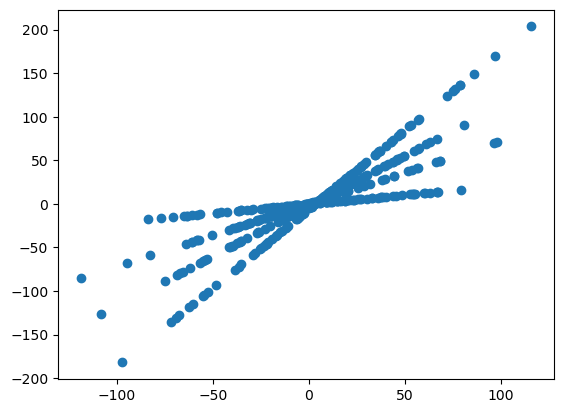

In [111]:
plt.scatter(mdf.fittedvalues, y)